# Import modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from scipy.spatial import procrustes # for Procrustes analysis
from scipy import stats # for correlation coefficients
from sklearn.decomposition import PCA # for principal component analysis
import statsmodels.stats.multitest as multi # for multiple test adjustment
from PIL import Image # for reading in California map

# Functions

In [2]:
def PolyArea(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def calc_gpa_mean(shape_arr):
    """
    input: a 3D array of shapes, shapes x 21 landmarks x 2 coordinates
    output: a generalized Procrustes mean
    """
    
    shape_list = shape_arr # using an array instead of list, rename variable input
    
    ref_ind = 0 # select a reference index to calculate procrustes distances to
    ref_shape = shape_list[ref_ind] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(shape_list)),21,2) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

        for i in range(len(shape_list)): # for each leaf shape after removing outliers

            s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    gpa_mean = new_mean
    
    return gpa_mean

def angle_between(p1, p2, p3):
    
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    
    """
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    
    angle_to_move = 270 - degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals


# Make a map of California sites

(547.276163, 644.927674, 584.0306274999999, 469.47512000000006)

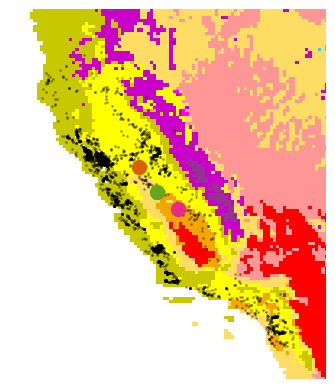

In [3]:
# Site coordinates:
# San Joaquin: 38.17578450221011, -121.27521161553807
# Merced: 37.38670273592184, -120.72221976953851
# Madera: 36.851484578653285, -120.05160968137915

# convert coordinates to x and y coordinate values
san_joaquin_x = (180+(-121.27521161553807))*10
merced_x = (180+(-120.72221976953851))*10
madera_x = (180+(-120.05160968137915))*10

san_joaquin_y = (90-(38.17578450221011))*10
merced_y = (90-(37.38670273592184))*10
madera_y = (90-(36.851484578653285))*10

# get coordinates of california wineries
ca_wine = pd.read_csv("just_CA_wineries.csv")
ca_wine["x"] = (180+ca_wine["Longitude"])*10
ca_wine["y"] = (90-ca_wine["Latitude"])*10
ca_wine["country"] = "california"

# remove an extreme Mojave Desert outlier
ca_wine = ca_wine.drop(ca_wine[ca_wine["x"]==680.0044300000001].index)

# set x and y lims of the map
west_ca = np.min(ca_wine["x"])
east_ca = np.max(ca_wine["x"])
south_ca = np.max(ca_wine["y"])
north_ca = np.min(ca_wine["y"])

# set map parameters
ca_pad = 10
site_s = 100
site_a = 1
pt_s = 1
pt_a = 0.3
map_alpha = 1

cab_col = "#7570b3" # lavender
chard_col = "#1b9e77" # green
san_joaquin_col = "#d95f02" # orange
merced_col = "#66a61e" # green
madera_col = "#e7298a" # magenta
col_5C = "#e6ab02" # gold
col_1103P = "#a6761d" # brown
col_freedom = "#666666" # charcoal

# plot
im = Image.open('current_map.tif')
plt.imshow(im, alpha=map_alpha)
plt.xlim((west_ca-ca_pad, east_ca+ca_pad))
plt.ylim((south_ca+ca_pad, north_ca-ca_pad))
plt.scatter(ca_wine["x"], ca_wine["y"], s=pt_s, alpha=pt_a, c="k")
plt.scatter(san_joaquin_x, san_joaquin_y, s=site_s, c=san_joaquin_col, alpha=site_a)
plt.scatter(merced_x, merced_y, s=site_s, c=merced_col, alpha=site_a)
plt.scatter(madera_x, madera_y, s=site_s, c=madera_col, alpha=site_a)
plt.axis("off")

#plt.savefig("california_map.png")

# Read in landmark data

In [4]:
df = pd.read_csv("./landmark_data.csv") # read in data, one coord per line
mdata = pd.read_csv("./metadata.csv") # read in metadata for later

num_landmarks = 21 # the number of landmarks

n = int(len(df)/num_landmarks) # calculate how many shapes

# Format data into a list of arrays for each leaf shape

In [5]:
shape_list = [] # a list of arrays for each leaf
order_list = [] # create an ordered ID for each leaf as it is read
sample_list = [] # list of sample IDs for each leaf

for i in range(n):
    
    start = 21*i # starting row index for current leaf
    end = start + 21 # ending row index for current leaf
    
    order_list.append("leaf_" + str(i)) # create an ordered ID for each leaf, store in order_list
    sample_list.append(df.iloc[start,2]) # get the current sample ID and store in sample_list
    
    xvals = df.iloc[start:end,3].to_list() # xvals current leaf
    yvals = df.iloc[start:end,4].to_list() # yvals current leaf
    
    leaf_vals = [] # list to store coords for current leaf, one array for each x & y val
     
    for j in range(num_landmarks): # for the number of landmarks
        
        leaf_vals.append([xvals[j], yvals[j]]) # append the current x & y array pair to leaf_vals
        
    leaf_array = np.array(leaf_vals) # turn the current leaf list into an array
    
    shape_list.append(leaf_array) # append the array for each leaf to the overall shape list


# Calculate mean Generalized Procrustes Analysis (GPA) shape

#### Remove problematic leaf shapes found while running the code below

In [6]:
##### leaf index 855 was found only to have (0,0) coordinates for all 21 landmarks

shape_list.pop(855)
order_list.pop(855)
sample_list.pop(855)

# leaf index 915 was found only to have (0,0) coordinates for all 21 landmarks
# NOTE: index 915 after removing the above sample FIRST

shape_list.pop(915)
order_list.pop(915)
sample_list.pop(915)

print(len(shape_list), len(order_list), len(sample_list))

1687 1687 1687


#### Calculate Procustes mean shape

In [7]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

mean_diff = 10**(-30) # set a distance between means to stop the algorithm

old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

d = 1000000 # set d initially arbitraily high

while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations
    
    arr = np.zeros( ((len(shape_list)),21,2) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

    for i in range(len(shape_list)): # for each leaf shape after removing outliers

        s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
        arr[i] = s2 # store procrustes adjusted shape to array

    new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference
    
    s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean
    
    print("the Procrustes distance between the old and new mean is", d) # print out difference between mean distance
    
    old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration
    
gpa_mean = new_mean


the Procrustes distance between the old and new mean is 0.023296087492761762
the Procrustes distance between the old and new mean is 6.011995243492124e-06
the Procrustes distance between the old and new mean is 2.3174238667442987e-09
the Procrustes distance between the old and new mean is 8.95526824861605e-13
the Procrustes distance between the old and new mean is 3.460801044451685e-16
the Procrustes distance between the old and new mean is 1.3374436849855038e-19
the Procrustes distance between the old and new mean is 5.1684815654852174e-23
the Procrustes distance between the old and new mean is 2.0079805291972535e-26
the Procrustes distance between the old and new mean is 8.387066805207378e-30
the Procrustes distance between the old and new mean is 9.475876252939011e-32


#### Check the Generalized Procrustes mean shape

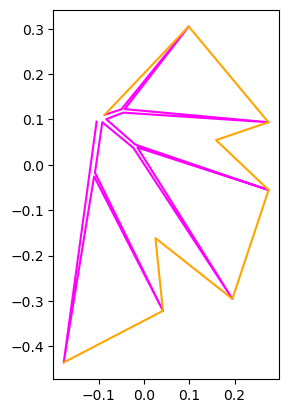

In [8]:
plt.plot(gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c="magenta")

plt.plot(gpa_mean[[0,13,14,15,16,17,18,19,20],0],
         gpa_mean[[0,13,14,15,16,17,18,19,20],1], c="orange")

plt.gca().set_aspect("equal")

# Calculate Procrustes-adjusted coordinates for each leaf against the calculated mean

In [9]:
proc_arr = np.zeros( ((len(shape_list)),21,2) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

for i in range(len(shape_list)): # for each leaf shape after removing outliers

    s1, s2, distance = procrustes(gpa_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

#### Visually check all Procrustes adjusted leaf shapes, plot with the gpa mean leaf

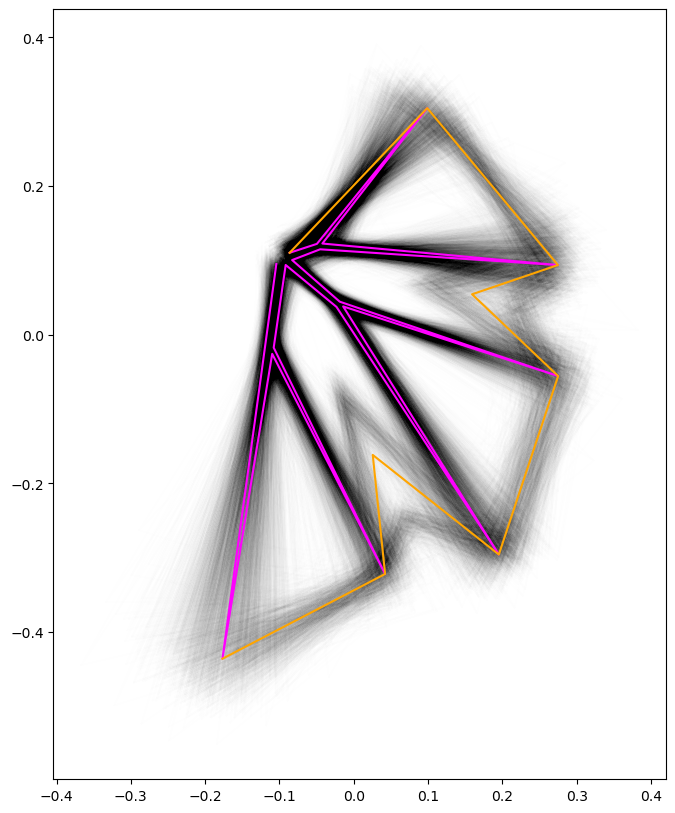

In [10]:
plot_col = "k" # set plot color
a = 0.005 # set alpha

plt.figure(figsize=(10,10))

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    plt.plot(curr_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
             curr_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], alpha=a, c=plot_col)

    plt.plot(curr_leaf[[0,13,14,15,16,17,18,19,20],0],
             curr_leaf[[0,13,14,15,16,17,18,19,20],1], alpha=a, c=plot_col)

    plt.gca().set_aspect("equal")
    
plt.plot(gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c="magenta")

plt.plot(gpa_mean[[0,13,14,15,16,17,18,19,20],0],
         gpa_mean[[0,13,14,15,16,17,18,19,20],1], c="orange")

plt.gca().set_aspect("equal")

# Combine metadata with shape data

#### Based on sample ID, create lists storing other metadata

In [11]:
rootstock_list = [] # store rootstock
scion_list = [] # store scion
location_list = [] # store location
year_list = [] # store year

for i in range(len(sample_list)): # for each sample

    curr_sample = sample_list[i] # get current sample

    rootstock = mdata.loc[mdata['sample'] == curr_sample]["rootstock"].values[0] # find corresponding meta data for each sample
    scion = mdata.loc[mdata['sample'] == curr_sample]["scion"].values[0]
    location = mdata.loc[mdata['sample'] == curr_sample]["location"].values[0]
    year = mdata.loc[mdata['sample'] == curr_sample]["year"].values[0]
    
    
    rootstock_list.append(rootstock) # append data to new lists
    scion_list.append(scion)
    location_list.append(location)
    year_list.append(year)
    

#### Calculate vein-to-blade ratio

In [12]:
vein_indices = [0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3] # vein indices for ploting
blade_indices = [0,13,14,15,16,17,18,19,20] # blade indices for ploting

vtb_list = [] # store vein-to-blade ratios for each leaf

for i in range(np.shape(proc_arr)[0]):
    
    vein_x = proc_arr[i][vein_indices,0]
    vein_y = proc_arr[i][vein_indices,1]
    blade_x = proc_arr[i][blade_indices,0]
    blade_y = proc_arr[i][blade_indices,1]
    
    vein_area = PolyArea(vein_x, vein_y)
    blade_area = PolyArea(blade_x, blade_y)-vein_area
    
    vtb_list.append(vein_area/blade_area)

In [13]:
# check that all metadata lists are the same length as number of shape samples

print(len(sample_list),
      len(rootstock_list),
      len(scion_list),
      len(location_list),
      len(year_list), 
      len(vtb_list)) # lengths of metadata lists

np.shape(proc_arr) # shape of array of shapes


1687 1687 1687 1687 1687 1687


(1687, 21, 2)

# Morphospace

In [14]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 10 
#######

reshape_scale = proc_arr.reshape(np.shape(proc_arr)[0], # use the reshape function to flatten to 2D
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2])  

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(reshape_scale) # fit a PCA for all data

print(pca_all.explained_variance_ratio_) # print out explained variance for each PC
print(pca_all.explained_variance_ratio_.cumsum())

[0.61453747 0.10494402 0.06208215 0.03891432 0.02856863 0.02279599
 0.01857009 0.01599473 0.01523544 0.0142494 ]
[0.61453747 0.7194815  0.78156365 0.82047796 0.84904659 0.87184258
 0.89041267 0.9064074  0.92164284 0.93589224]


In [15]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(reshape_scale) # fit a PCA for only desired PCs

print(pca.explained_variance_ratio_) # print out explained variance for each PC
print(pca.explained_variance_ratio_.cumsum())

# create dataframe for plotting
pca_df = pd.DataFrame(data={"scion":scion_list,
                            "rootstock":rootstock_list,
                            "location":location_list,
                            "year":year_list,
                            "vtb_ratio":vtb_list,
                            "PC1":PCs[:,0],
                            "PC2":PCs[:,1]
                           })

[0.61453747 0.10494402]
[0.61453747 0.7194815 ]


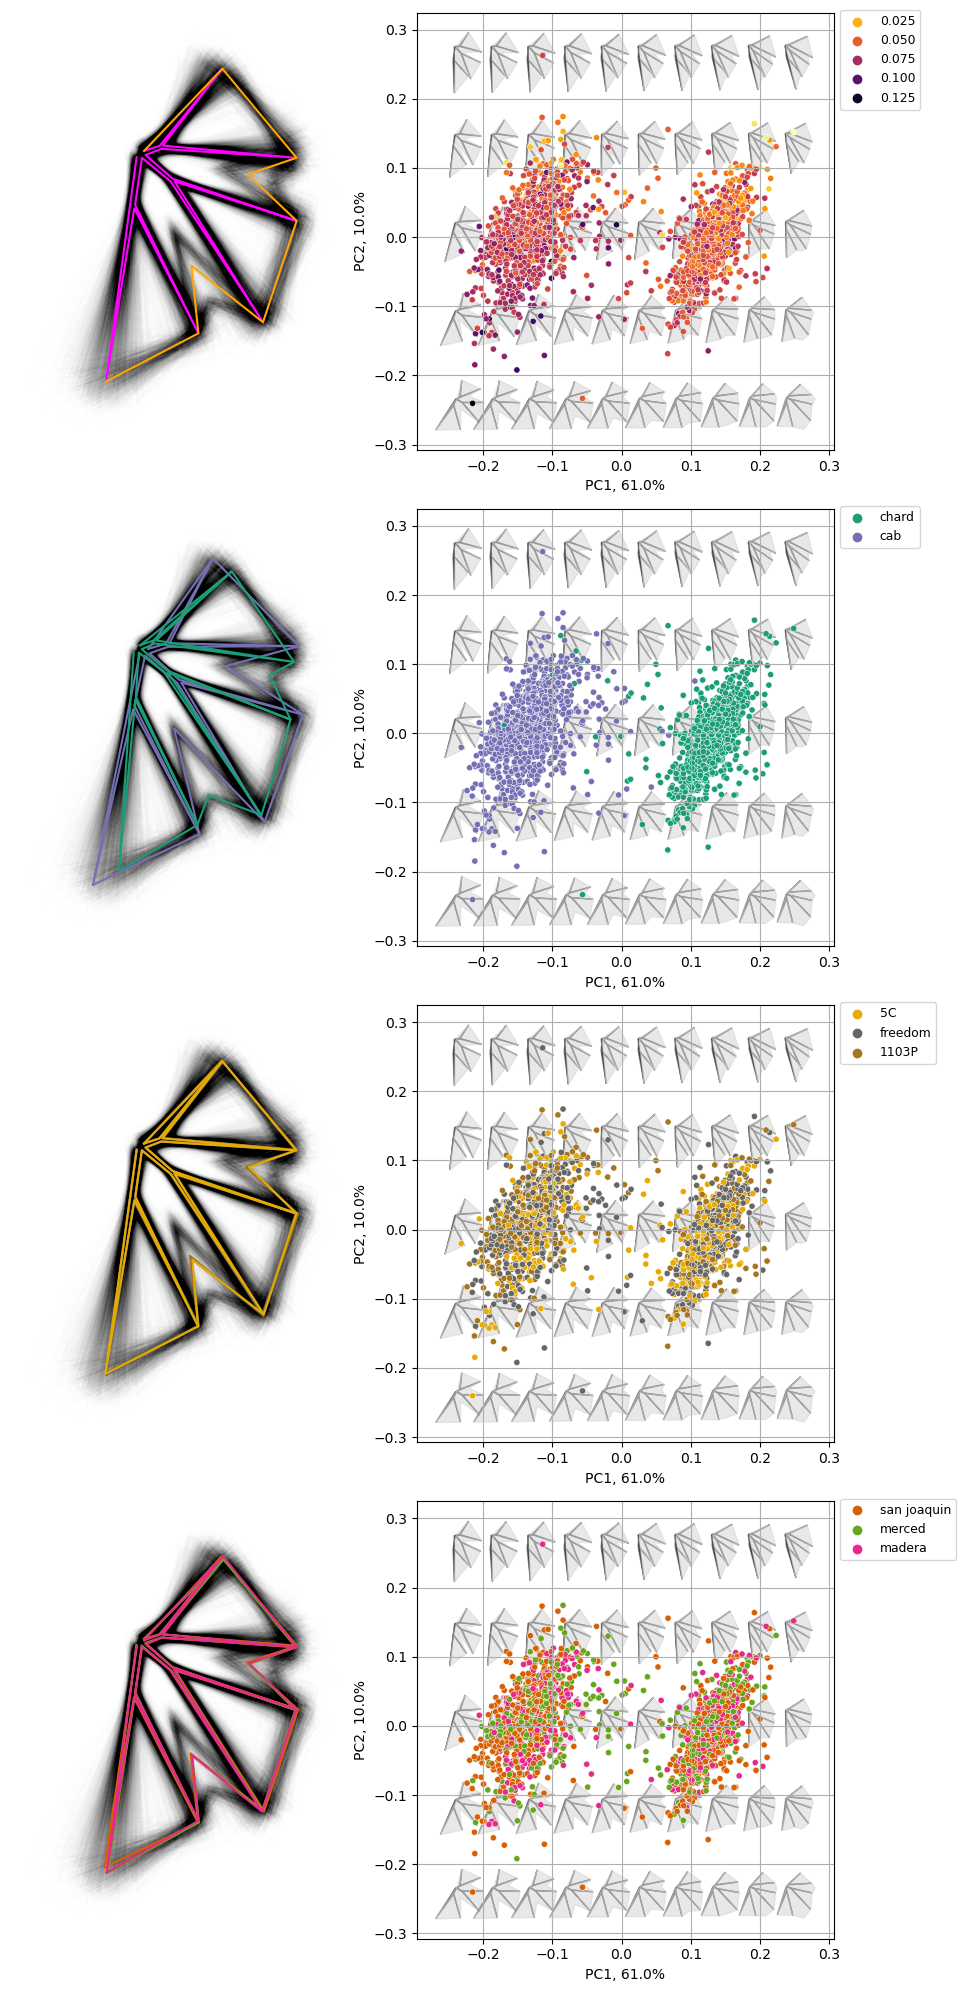

In [16]:
##########################
### CREATE MORPHOSPACE ###
##########################

numPC1 = 10 # set PC1 intervals
numPC2 = 5 # set PC2 intervals
vein_indices = [0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3] # vein indices for ploting
blade_indices = [0,13,14,15,16,17,18,19,20] # blade indices for ploting
s = 0.1 # set the scale of eigenleaves
pca_pts = 20 # PCA point size
pca_a = 1 # PCA point alpha
grid_a = 0.5 # set alpha of grid lines
axis_fs = 12 # fontsize of axis labels
leg = "auto" # legend, False/"auto"
label_fs = 10 # set label font size
tick_fs = 10 # set tick size
eigen_blade_col = "lightgray" # set eigenleaf blade color
eigen_vein_col = "black" # set eigenleaf vein color
eigen_blade_a = 0.5 # set eigenleaf blade alpha
eigen_vein_a = 0.5 # set eigenleaf vein alpha
plot_col = "k" # set leaf plot color
a = 0.005 # set leaf plot alpha

cab_col = "#7570b3" # lavender
chard_col = "#1b9e77" # green
san_joaquin_col = "#d95f02" # orange
merced_col = "#66a61e" # green
madera_col = "#e7298a" # magenta
col_5C = "#e6ab02" # gold
col_1103P = "#a6761d" # brown
col_freedom = "#666666" # charcoal

xlab = "PC1, " + str(np.round(pca.explained_variance_ratio_[0],2)*100) + "%" # x-axis label
ylab = "PC2, " + str(np.round(pca.explained_variance_ratio_[1],2)*100) + "%" # y-axis label

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

plt.figure(figsize=(10,20))

#####################################
##### ax1: Procrustes mean leaf #####
#####################################

ax1 = plt.subplot(4,2,1)

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    ax1.plot(curr_leaf[vein_indices,0],
             curr_leaf[vein_indices,1], alpha=a, c=plot_col)

    ax1.plot(curr_leaf[blade_indices,0],
             curr_leaf[blade_indices,1], alpha=a, c=plot_col)

    ax1.set_aspect("equal")
    
ax1.plot(gpa_mean[vein_indices,0],
         gpa_mean[vein_indices,1], c="magenta")

ax1.plot(gpa_mean[blade_indices,0],
         gpa_mean[blade_indices,1], c="orange")

ax1.set_aspect("equal")
ax1.axis("off")

########################################
##### ax2: vein-to-blade ratio PCA #####
########################################

ax2 = plt.subplot(4,2,2)

for i in PC1_vals:
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax2.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax2.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)
        
sns.scatterplot(ax=ax2, 
                data=pca_df, 
                x="PC1", 
                y="PC2", 
                hue="vtb_ratio", 
                s=pca_pts, 
                lw=0, 
                alpha=pca_a, 
                legend=leg, 
                palette="inferno_r"
               )

ax2.legend(bbox_to_anchor=(1.0, 1.02), prop={'size': 8.9})
ax2.set_xlabel(xlab, fontsize=label_fs)
ax2.set_ylabel(ylab, fontsize=label_fs)
ax2.tick_params(axis='both', labelsize=tick_fs)
ax2.set_aspect("equal", "box")
ax2.set_facecolor("white")
ax2.grid(grid_a)

##################################
##### ax3: scion mean leaves #####
##################################

ax3 = plt.subplot(4,2,3)

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    ax3.plot(curr_leaf[vein_indices,0],
             curr_leaf[vein_indices,1], alpha=a, c=plot_col)

    ax3.plot(curr_leaf[blade_indices,0],
             curr_leaf[blade_indices,1], alpha=a, c=plot_col)

    ax3.set_aspect("equal")

cab_indices = pca_df["scion"]=="cab"
cab_mean = np.mean(proc_arr[cab_indices], axis=0)

ax3.plot(cab_mean[vein_indices][:,0],
         cab_mean[vein_indices][:,1], c=cab_col)

ax3.plot(cab_mean[blade_indices][:,0],
         cab_mean[blade_indices][:,1], c=cab_col)

chard_indices = pca_df["scion"]=="chard"
chard_mean = np.mean(proc_arr[chard_indices], axis=0)

ax3.plot(chard_mean[vein_indices][:,0],
         chard_mean[vein_indices][:,1], c=chard_col)

ax3.plot(chard_mean[blade_indices][:,0],
         chard_mean[blade_indices][:,1], c=chard_col)

ax3.set_aspect("equal")
ax3.axis("off")

##########################
##### ax4: scion PCA #####
##########################

ax4 = plt.subplot(4,2,4)

for i in PC1_vals:
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax4.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax4.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)
        
sns.scatterplot(ax=ax4, 
                data=pca_df, 
                x="PC1", 
                y="PC2", 
                hue="scion", 
                s=pca_pts, 
                lw=0, 
                alpha=pca_a, 
                legend=leg, 
                palette=[chard_col, cab_col]
               )

ax4.legend(bbox_to_anchor=(1.0, 1.02), prop={'size': 8.9})
ax4.set_xlabel(xlab, fontsize=label_fs)
ax4.set_ylabel(ylab, fontsize=label_fs)
ax4.tick_params(axis='both', labelsize=tick_fs)
ax4.set_aspect("equal", "box")
ax4.set_facecolor("white")
ax4.grid(grid_a)

######################################
##### ax5: rootstock mean leaves #####
######################################

ax5 = plt.subplot(4,2,5)

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    ax5.plot(curr_leaf[vein_indices,0],
             curr_leaf[vein_indices,1], alpha=a, c=plot_col)

    ax5.plot(curr_leaf[blade_indices,0],
             curr_leaf[blade_indices,1], alpha=a, c=plot_col)

    ax5.set_aspect("equal")

r1103P_indices = pca_df["rootstock"]=="1103P"
r1103P_mean = np.mean(proc_arr[r1103P_indices], axis=0)

ax5.plot(r1103P_mean[vein_indices][:,0],
         r1103P_mean[vein_indices][:,1], c=col_1103P)

ax5.plot(r1103P_mean[blade_indices][:,0],
         r1103P_mean[blade_indices][:,1], c=col_1103P)

rfreedom_indices = pca_df["rootstock"]=="freedom"
rfreedom_mean = np.mean(proc_arr[rfreedom_indices], axis=0)

ax5.plot(rfreedom_mean[vein_indices][:,0],
         rfreedom_mean[vein_indices][:,1], c=col_freedom)

ax5.plot(rfreedom_mean[blade_indices][:,0],
         rfreedom_mean[blade_indices][:,1], c=col_freedom)

r5C_indices = pca_df["rootstock"]=="5C"
r5C_mean = np.mean(proc_arr[r5C_indices], axis=0)

ax5.plot(r5C_mean[vein_indices][:,0],
         r5C_mean[vein_indices][:,1], c=col_5C)

ax5.plot(r5C_mean[blade_indices][:,0],
         r5C_mean[blade_indices][:,1], c=col_5C)

ax5.set_aspect("equal")
ax5.axis("off")

##############################
##### ax6: rootstock PCA #####
##############################

ax6 = plt.subplot(4,2,6)

for i in PC1_vals:
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax6.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax6.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)
        
sns.scatterplot(ax=ax6, 
                data=pca_df, 
                x="PC1", 
                y="PC2", 
                hue="rootstock", 
                s=pca_pts, 
                lw=0, 
                alpha=pca_a, 
                legend=leg, 
                palette=[col_5C, col_freedom, col_1103P]
               )

ax6.legend(bbox_to_anchor=(1.0, 1.02), prop={'size': 8.9})
ax6.set_xlabel(xlab, fontsize=label_fs)
ax6.set_ylabel(ylab, fontsize=label_fs)
ax6.tick_params(axis='both', labelsize=tick_fs)
ax6.set_aspect("equal", "box")
ax6.set_facecolor("white")
ax6.grid(grid_a)

#####################################
##### ax7: location mean leaves #####
#####################################

ax7 = plt.subplot(4,2,7)

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    ax7.plot(curr_leaf[vein_indices,0],
             curr_leaf[vein_indices,1], alpha=a, c=plot_col)

    ax7.plot(curr_leaf[blade_indices,0],
             curr_leaf[blade_indices,1], alpha=a, c=plot_col)

    ax7.set_aspect("equal")

san_joaquin_indices = pca_df["location"]=="san joaquin"
san_joaquin_mean = np.mean(proc_arr[san_joaquin_indices], axis=0)

ax7.plot(san_joaquin_mean[vein_indices][:,0],
         san_joaquin_mean[vein_indices][:,1], c=san_joaquin_col)

ax7.plot(san_joaquin_mean[blade_indices][:,0],
         san_joaquin_mean[blade_indices][:,1], c=san_joaquin_col)

merced_indices = pca_df["location"]=="merced"
merced_mean = np.mean(proc_arr[merced_indices], axis=0)

ax7.plot(merced_mean[vein_indices][:,0],
         merced_mean[vein_indices][:,1], c=merced_col)

ax7.plot(merced_mean[blade_indices][:,0],
         merced_mean[blade_indices][:,1], c=merced_col)

madera_indices = pca_df["location"]=="madera"
madera_mean = np.mean(proc_arr[madera_indices], axis=0)

ax7.plot(madera_mean[vein_indices][:,0],
         madera_mean[vein_indices][:,1], c=madera_col)

ax7.plot(madera_mean[blade_indices][:,0],
         madera_mean[blade_indices][:,1], c=madera_col)

ax7.set_aspect("equal")
ax7.axis("off")

#############################
##### ax8: location PCA #####
#############################

ax8 = plt.subplot(4,2,8)

for i in PC1_vals:
    for j in PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax8.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax8.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)
        
sns.scatterplot(ax=ax8, 
                data=pca_df, 
                x="PC1", 
                y="PC2", 
                hue="location", 
                s=pca_pts, 
                lw=0, 
                alpha=pca_a, 
                legend=leg, 
                palette=[san_joaquin_col, merced_col, madera_col]
               )

ax8.legend(bbox_to_anchor=(1.0, 1.02), prop={'size': 8.9})
ax8.set_xlabel(xlab, fontsize=label_fs)
ax8.set_ylabel(ylab, fontsize=label_fs)
ax8.tick_params(axis='both', labelsize=tick_fs)
ax8.set_aspect("equal", "box")
ax8.set_facecolor("white")
ax8.grid(grid_a)

plt.tight_layout()

#plt.savefig("morphospace.png")



#### Correlations of Cab and Chard vein-to-blade ratio

In [17]:
cab_pca_df = pca_df[pca_df["scion"]=="cab"]

stats.spearmanr(cab_pca_df["vtb_ratio"], cab_pca_df["PC2"])


SignificanceResult(statistic=-0.40848596116815034, pvalue=4.0469953146980624e-35)

In [18]:
chard_pca_df = pca_df[pca_df["scion"]=="chard"]

stats.spearmanr(chard_pca_df["vtb_ratio"], chard_pca_df["PC2"])

SignificanceResult(statistic=-0.2405254690513635, pvalue=1.301588907818583e-12)

# Statistical leaf comparisons

In [19]:
comp = pd.read_csv("comparisons.csv")

len_comp1_18 = []
len_comp1_19 = []
len_comp2_18 = []
len_comp2_19 = []
proc_dist_comp = []
proc_dist_all = []
pvals = []

for i in range(len(comp)):
    
    print(i)

    curr_comp = comp.iloc[i]

    # samples of the first comparison
    curr_df1 = pca_df[pca_df["scion"]==curr_comp["scion"]]
    curr_df1 = curr_df1[curr_df1["location"]==curr_comp["loc1"]]
    curr_df1 = curr_df1[curr_df1["rootstock"]==curr_comp["root1"]]
    # append number of samples from each year
    len_comp1_18.append(len(curr_df1[curr_df1["year"]=="y2018"]))
    len_comp1_19.append(len(curr_df1[curr_df1["year"]=="y2019"]))
    # get indices of first comparison for procrustes mean shape
    df1_indices = list(curr_df1.index)
    df1_arr = proc_arr[df1_indices]
    df1_mean_shape = calc_gpa_mean(df1_arr)

    # samples of the second comparison
    curr_df2 = pca_df[pca_df["scion"]==curr_comp["scion"]]
    curr_df2 = curr_df2[curr_df2["location"]==curr_comp["loc2"]]
    curr_df2 = curr_df2[curr_df2["rootstock"]==curr_comp["root2"]]
    curr_df2 = curr_df2.reset_index()
    # append number of samples from each year
    len_comp2_18.append(len(curr_df2[curr_df2["year"]=="y2018"]))
    len_comp2_19.append(len(curr_df2[curr_df2["year"]=="y2019"]))
    # get indices of second comparison for procrustes mean shape
    df2_indices = list(curr_df2.index)
    df2_arr = proc_arr[df2_indices]
    df2_mean_shape = calc_gpa_mean(df2_arr)

    # combine all samples together
    curr_df3 = pd.concat([curr_df1, curr_df2])
    # get indices of all samples for procrustes mean shape
    df3_indices = list(curr_df3.index)
    df3_arr = proc_arr[df3_indices]
    df3_mean_shape = calc_gpa_mean(df3_arr)

    # calculate distances of df1 leaves to df1 mean and append to comparisons
    for j in range(len(df1_arr)):
        curr_shape = df1_arr[j]
        s1, s2, distance = procrustes(df1_mean_shape, curr_shape) 
        proc_dist_comp.append(distance)

    # calculate distances of df2 leaves to df2 mean and append to comparisons
    for j in range(len(df2_arr)):
        curr_shape = df2_arr[j]
        s1, s2, distance = procrustes(df2_mean_shape, curr_shape) 
        proc_dist_comp.append(distance)

    # calculate distances of df3 leaves to df3 mean and append to all
    for j in range(len(df3_arr)):
        curr_shape = df3_arr[j]
        s1, s2, distance = procrustes(df3_mean_shape, curr_shape) 
        proc_dist_all.append(distance)

    p_value = stats.kruskal(proc_dist_comp, proc_dist_all)

    pvals.append(p_value[1])
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [20]:
# add Bonferroni adjusted p values to the comparison dataframae

comp["bonf_pvals"] = multi.multipletests(pvals, method="Bonferroni")[1]

comp

# comp.to_csv("leaf_shape_tablel.csv")

,ID,type,scion,loc1,root1,loc2,root2,bonf_pvals
0,1,root,cab,san joaquin,5C,san joaquin,1103P,1.000000e+00
1,2,root,cab,san joaquin,5C,san joaquin,freedom,1.000000e+00
2,3,root,cab,san joaquin,1103P,san joaquin,freedom,1.000000e+00
3,4,root,chard,san joaquin,5C,san joaquin,1103P,1.564346e-01
4,5,root,chard,san joaquin,5C,san joaquin,freedom,5.048422e-05
5,6,root,chard,san joaquin,1103P,san joaquin,freedom,7.619546e-09
6,7,root,cab,merced,1103P,merced,freedom,5.180113e-08
7,8,root,chard,merced,5C,merced,freedom,6.477558e-11
8,9,root,cab,madera,5C,madera,freedom,9.671299e-10
9,10,root,chard,madera,1103P,madera,freedom,3.659836e-18


# Visualize leaf comparisons

In [21]:
magnification = 4 # set the magnification

for i in range(len(comp)):
    
    print(i)
    
    comp_ind = i
    
    if comp["bonf_pvals"].iloc[comp_ind]>0.05:
        continue

    # get the type of comparison
    comp_type = comp["type"].iloc[comp_ind]

    # get the scion
    common_scion = comp["scion"].iloc[comp_ind]

    # if a root comparison, set parameters
    if comp_type=="root":

        common_var = comp["loc1"].iloc[comp_ind]

        root1_id = comp["root1"].iloc[comp_ind]
        root2_id = comp["root2"].iloc[comp_ind]
        diff_var1 = comp["root1"].iloc[comp_ind]
        diff_var2 = comp["root2"].iloc[comp_ind]

        if root1_id == "5C":
            col1 = col_5C
        elif root1_id == "1103P":
            col1 = col_1103P
        elif root1_id == "freedom":
            col1 = col_freedom

        if root2_id == "5C":
            col2 = col_5C
        elif root2_id == "1103P":
            col2 = col_1103P
        elif root2_id == "freedom":
            col2 = col_freedom

    # if a location comparison, set parameters
    elif comp_type=="loc":

        common_var = comp["root1"].iloc[comp_ind]

        loc1_id = comp["loc1"].iloc[comp_ind]
        loc2_id = comp["loc2"].iloc[comp_ind]
        diff_var1 = comp["loc1"].iloc[comp_ind]
        diff_var2 = comp["loc2"].iloc[comp_ind]

        if loc1_id == "san joaquin":
            col1 = san_joaquin_col
        elif loc1_id == "merced":
            col1 = merced_col
        elif loc1_id == "madera":
            col1 = madera_col

        if loc2_id == "san joaquin":
            col2 = san_joaquin_col
        elif loc2_id == "merced":
            col2 = merced_col
        elif loc2_id == "madera":
            col2 = madera_col

    # set title
    title_name = str(comp_ind+1) + comp_type + common_scion + common_var + diff_var1 + diff_var2

    # get variable values
    scion = comp["scion"].iloc[comp_ind]
    loc1 = comp["loc1"].iloc[comp_ind]
    root1 = comp["root1"].iloc[comp_ind]
    loc2 = comp["loc2"].iloc[comp_ind]
    root2 = comp["root2"].iloc[comp_ind]

    # get mean of first leaf
    curr_df1 = pca_df[pca_df["scion"]==scion]
    curr_df1 = curr_df1[curr_df1["location"]==loc1]
    curr_df1 = curr_df1[curr_df1["rootstock"]==root1]
    df1_indices = list(curr_df1.index)
    df1_arr = proc_arr[df1_indices]
    df1_mean_shape = calc_gpa_mean(df1_arr)

    # get mean of second leaf
    curr_df2 = pca_df[pca_df["scion"]==scion]
    curr_df2 = curr_df2[curr_df2["location"]==loc2]
    curr_df2 = curr_df2[curr_df2["rootstock"]==root2]
    df2_indices = list(curr_df2.index)
    df2_arr = proc_arr[df2_indices]
    df2_mean_shape = calc_gpa_mean(df2_arr)

    # calculate magnified leaf 2 relative to leaf 1
    mag_leaf2 = (df2_mean_shape - df1_mean_shape)*magnification + df1_mean_shape

    # calculate magnified leaf 1 relative to leaf 2
    mag_leaf1 = (df1_mean_shape - df2_mean_shape)*magnification + df2_mean_shape

    # rotated and scaled leaf 1
    df1_pet_junc = np.mean((df1_mean_shape[0,:], df1_mean_shape[1,:], df1_mean_shape[2,:], df1_mean_shape[3,:]), axis=0)
    df1_tip = df1_mean_shape[20,:]
    curr_angle = angle_between(df1_tip, df1_pet_junc, [df1_pet_junc[0]+10, df1_pet_junc[1]])
    df1_rotx, df1_roty = rotate_points(df1_mean_shape[:,0],df1_mean_shape[:,1], curr_angle)
    rot_df1 = np.column_stack((df1_rotx, df1_roty))
    rot_df1_pet_junc = np.mean((rot_df1[0,:], rot_df1[1,:], rot_df1[2,:], rot_df1[3,:]), axis=0)
    rot_df1 = rot_df1-rot_df1_pet_junc
    df1_len = np.sqrt( (rot_df1[20,0])**2 + (rot_df1[20,1])**2 )
    rot_df1 = rot_df1/df1_len

    # rotated and scaled leaf 2
    df2_pet_junc = np.mean((df2_mean_shape[0,:], df2_mean_shape[1,:], df2_mean_shape[2,:], df2_mean_shape[3,:]), axis=0)
    df2_tip = df2_mean_shape[20,:]
    curr_angle = angle_between(df2_tip, df2_pet_junc, [df2_pet_junc[0]+10, df2_pet_junc[1]])
    df2_rotx, df2_roty = rotate_points(df2_mean_shape[:,0],df2_mean_shape[:,1], curr_angle)
    rot_df2 = np.column_stack((df2_rotx, df2_roty))
    rot_df2_pet_junc = np.mean((rot_df2[0,:], rot_df2[1,:], rot_df2[2,:], rot_df2[3,:]), axis=0)
    rot_df2 = rot_df2-rot_df2_pet_junc
    df2_len = np.sqrt( (rot_df2[20,0])**2 + (rot_df2[20,1])**2 )
    rot_df2 = rot_df2/df2_len

    # rotated and scaled magnified leaf 1
    m1_pet_junc = np.mean((mag_leaf1[0,:], mag_leaf1[1,:], mag_leaf1[2,:], mag_leaf1[3,:]), axis=0)
    m1_tip = mag_leaf1[20,:]
    curr_angle = angle_between(m1_tip, m1_pet_junc, [m1_pet_junc[0]+10, m1_pet_junc[1]])
    m1_rotx, m1_roty = rotate_points(mag_leaf1[:,0],mag_leaf1[:,1], curr_angle)
    rot_m1 = np.column_stack((m1_rotx, m1_roty))
    rot_m1_pet_junc = np.mean((rot_m1[0,:], rot_m1[1,:], rot_m1[2,:], rot_m1[3,:]), axis=0)
    rot_m1 = rot_m1-rot_m1_pet_junc
    m1_len = np.sqrt( (rot_m1[20,0])**2 + (rot_m1[20,1])**2 )
    rot_m1 = rot_m1/m1_len

    # rotated and scaled magnified leaf 2
    m2_pet_junc = np.mean((mag_leaf2[0,:], mag_leaf2[1,:], mag_leaf2[2,:], mag_leaf2[3,:]), axis=0)
    m2_tip = mag_leaf2[20,:]
    curr_angle = angle_between(m2_tip, m2_pet_junc, [m2_pet_junc[0]+10, m2_pet_junc[1]])
    m2_rotx, m2_roty = rotate_points(mag_leaf2[:,0],mag_leaf2[:,1], curr_angle)
    rot_m2 = np.column_stack((m2_rotx, m2_roty))
    rot_m2_pet_junc = np.mean((rot_m2[0,:], rot_m2[1,:], rot_m2[2,:], rot_m2[3,:]), axis=0)
    rot_m2 = rot_m2-rot_m2_pet_junc
    m2_len = np.sqrt( (rot_m2[20,0])**2 + (rot_m2[20,1])**2 )
    rot_m2 = rot_m2/m2_len

    # plot
    
    plt.figure()

    ax1 = plt.subplot(1,2,1)
    ax1.plot(rot_df1[vein_indices,0],
             rot_df1[vein_indices,1],
             c=col1)
    ax1.plot(rot_df1[blade_indices,0],
             rot_df1[blade_indices,1],
             c=col1)
    ax1.plot(rot_m2[vein_indices,0],
             rot_m2[vein_indices,1],
             c=col2,
             linestyle="dotted")
    ax1.plot(rot_m2[blade_indices,0],
             rot_m2[blade_indices,1],
             c=col2,
             linestyle="dotted")
    ax1.set_aspect("equal")
    ax1.axis("off")

    ax2 = plt.subplot(1,2,2)
    ax2.plot(rot_df2[vein_indices,0],
             rot_df2[vein_indices,1],
             c=col2)
    ax2.plot(rot_df2[blade_indices,0],
             rot_df2[blade_indices,1],
             c=col2)
    ax2.plot(rot_m1[vein_indices,0],
             rot_m1[vein_indices,1],
             c=col1,
             linestyle="dotted")
    ax2.plot(rot_m1[blade_indices,0],
             rot_m1[blade_indices,1],
             c=col1,
             linestyle="dotted")
    ax2.set_aspect("equal")
    ax2.axis("off")
    
    plt.suptitle(title_name)
    
    #plt.savefig("./compare_shapes/" + title_name + ".jpg")
    
    plt.close()




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# Export table of comparisons

In [22]:
comp["n_2018_1"] = len_comp1_18
comp["n_2018_2"] = len_comp2_18
comp["n_2019_1"] = len_comp1_19
comp["n_2019_2"] = len_comp2_19

In [23]:
#comp.to_csv("leaf_shape_table.csv")

# Visualize differences

#### Store magnified leaves and associated data

In [24]:
magnification = 4 # set the magnification

comp_types = [] # to store comparison types
scion_id = [] # store scion type
var1_id = [] # to store ID of first variable
var2_id = [] # to store ID of second variable
col1_id = [] # color of first variable
col2_id = [] # color of second variable

mag_arr = np.zeros((16*2,21,2)) # to store magnified leaf shapes

j = 0 # counter of magnified leaf shapes calculated

for i in range(len(comp)):
    
    print(i)
    
    comp_ind = i
    
    if comp["bonf_pvals"].iloc[comp_ind]>0.05:
        continue

    # get the type of comparison
    comp_type = comp["type"].iloc[comp_ind]
    comp_types.append(comp_type)

    # get the scion
    common_scion = comp["scion"].iloc[comp_ind]
    scion_id.append(common_scion)

    # if a root comparison, set parameters
    if comp_type=="root":

        common_var = comp["loc1"].iloc[comp_ind]

        root1_id = comp["root1"].iloc[comp_ind]
        root2_id = comp["root2"].iloc[comp_ind]
        diff_var1 = comp["root1"].iloc[comp_ind]
        diff_var2 = comp["root2"].iloc[comp_ind]

        if root1_id == "5C":
            col1 = col_5C
        elif root1_id == "1103P":
            col1 = col_1103P
        elif root1_id == "freedom":
            col1 = col_freedom

        if root2_id == "5C":
            col2 = col_5C
        elif root2_id == "1103P":
            col2 = col_1103P
        elif root2_id == "freedom":
            col2 = col_freedom

    # if a location comparison, set parameters
    elif comp_type=="loc":

        common_var = comp["root1"].iloc[comp_ind]

        loc1_id = comp["loc1"].iloc[comp_ind]
        loc2_id = comp["loc2"].iloc[comp_ind]
        diff_var1 = comp["loc1"].iloc[comp_ind]
        diff_var2 = comp["loc2"].iloc[comp_ind]

        if loc1_id == "san joaquin":
            col1 = san_joaquin_col
        elif loc1_id == "merced":
            col1 = merced_col
        elif loc1_id == "madera":
            col1 = madera_col

        if loc2_id == "san joaquin":
            col2 = san_joaquin_col
        elif loc2_id == "merced":
            col2 = merced_col
        elif loc2_id == "madera":
            col2 = madera_col
            
    # store variables that differ
    var1_id.append(diff_var1)
    var2_id.append(diff_var2)
    
    # store variable colors
    col1_id.append(col1)
    col2_id.append(col2)

    # set title
    title_name = str(comp_ind+1) + comp_type + common_scion + common_var + diff_var1 + diff_var2

    # get variable values
    scion = comp["scion"].iloc[comp_ind]
    loc1 = comp["loc1"].iloc[comp_ind]
    root1 = comp["root1"].iloc[comp_ind]
    loc2 = comp["loc2"].iloc[comp_ind]
    root2 = comp["root2"].iloc[comp_ind]

    # get mean of first leaf
    curr_df1 = pca_df[pca_df["scion"]==scion]
    curr_df1 = curr_df1[curr_df1["location"]==loc1]
    curr_df1 = curr_df1[curr_df1["rootstock"]==root1]
    df1_indices = list(curr_df1.index)
    df1_arr = proc_arr[df1_indices]
    df1_mean_shape = calc_gpa_mean(df1_arr)

    # get mean of second leaf
    curr_df2 = pca_df[pca_df["scion"]==scion]
    curr_df2 = curr_df2[curr_df2["location"]==loc2]
    curr_df2 = curr_df2[curr_df2["rootstock"]==root2]
    df2_indices = list(curr_df2.index)
    df2_arr = proc_arr[df2_indices]
    df2_mean_shape = calc_gpa_mean(df2_arr)

    # calculate magnified leaf 2 relative to leaf 1
    mag_leaf2 = (df2_mean_shape - df1_mean_shape)*magnification + df1_mean_shape

    # calculate magnified leaf 1 relative to leaf 2
    mag_leaf1 = (df1_mean_shape - df2_mean_shape)*magnification + df2_mean_shape
    
    # store magnified leaves
    mag_arr[j*2] = mag_leaf1
    mag_arr[j*2+1] = mag_leaf2
    
    # add to counter if a magnified leaf is added
    j += 1
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


#### Separate Cab from Chard

In [25]:
cab_types = []
cab_vars = []
cab_cols = []
cab_mag_arr = np.zeros((7,21,2))

chard_types = []
chard_vars = []
chard_cols = []
chard_mag_arr = np.zeros((9,21,2))

for i in range(len(scion_id)):
    if scion_id[i]=="cab":
        cab_types.append(comp_types[i])
        cab_types.append(comp_types[i])
        cab_vars.append(var1_id[i])
        cab_vars.append(var2_id[i])
        cab_cols.append(col1_id[i])
        cab_cols.append(col2_id[i])
        
    elif scion_id[i]=="chard":
        chard_types.append(comp_types[i])
        chard_types.append(comp_types[i])
        chard_vars.append(var1_id[i])
        chard_vars.append(var2_id[i])
        chard_cols.append(col1_id[i])
        chard_cols.append(col2_id[i])

cab_inds = [2,4,6,8,10,11,12]
chard_inds = [0,1,3,5,7,9,13,14,15]

cab_arr_inds = np.sort(np.concatenate( (np.array(cab_inds)*2,np.array(cab_inds)*2+1)))
chard_arr_inds = np.sort(np.concatenate( (np.array(chard_inds)*2,np.array(chard_inds)*2+1)))

cab_mag_arr = mag_arr[cab_arr_inds]
chard_mag_arr = mag_arr[chard_arr_inds]


#### Cab PCA

In [26]:
#####################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL CAB PCs ###
#####################################################

######
PC_NUMBER = 10 
#######

reshape_scale = cab_mag_arr.reshape(np.shape(cab_mag_arr)[0], # use the reshape function to flatten to 2D
                                 np.shape(cab_mag_arr)[1]*np.shape(cab_mag_arr)[2])  

cab_pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = cab_pca_all.fit_transform(reshape_scale) # fit a PCA for all data

print(cab_pca_all.explained_variance_ratio_) # print out explained variance for each PC
print(cab_pca_all.explained_variance_ratio_.cumsum())

#########################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs for CAB ###
#########################################################

######
PC_NUMBER = 2
#######

cab_pca = PCA(n_components=PC_NUMBER) 
cab_PCs = cab_pca.fit_transform(reshape_scale) # fit a PCA for only desired PCs

# create dataframe for plotting
cab_pca_df = pd.DataFrame(data={
                            "type":cab_types,
                            "var":cab_vars,
                            "col":cab_cols,
                            "PC1":cab_PCs[:,0],
                            "PC2":cab_PCs[:,1]
                           })


[7.22277415e-01 1.43708259e-01 1.07512059e-01 1.41285759e-02
 9.80663147e-03 2.56706063e-03 5.73819025e-31 1.77406907e-32
 4.44490594e-33 2.66273005e-33]
[0.72227741 0.86598567 0.97349773 0.98762631 0.99743294 1.
 1.         1.         1.         1.        ]


#### Chard PCA

In [27]:
#######################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL CHARD PCs ###
#######################################################

######
PC_NUMBER = 10 
#######

reshape_scale = chard_mag_arr.reshape(np.shape(chard_mag_arr)[0], # use the reshape function to flatten to 2D
                                 np.shape(chard_mag_arr)[1]*np.shape(chard_mag_arr)[2])  

chard_pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = chard_pca_all.fit_transform(reshape_scale) # fit a PCA for all data

print(chard_pca_all.explained_variance_ratio_) # print out explained variance for each PC
print(chard_pca_all.explained_variance_ratio_.cumsum())

###########################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs for CHARD ###
###########################################################

######
PC_NUMBER = 2
#######

chard_pca = PCA(n_components=PC_NUMBER) 
chard_PCs = chard_pca.fit_transform(reshape_scale) # fit a PCA for only desired PCs

# create dataframe for plotting
chard_pca_df = pd.DataFrame(data={
                            "type":chard_types,
                            "var":chard_vars,
                            "col":chard_cols,
                            "PC1":chard_PCs[:,0],
                            "PC2":chard_PCs[:,1]
                           })

[7.32197433e-01 1.19004241e-01 8.07374554e-02 4.07766873e-02
 1.92865164e-02 7.99766646e-03 6.66838518e-31 1.03807656e-32
 8.13581012e-33 5.56715692e-33]
[0.73219743 0.85120167 0.93193913 0.97271582 0.99200233 1.
 1.         1.         1.         1.        ]


#### Create PCA plots

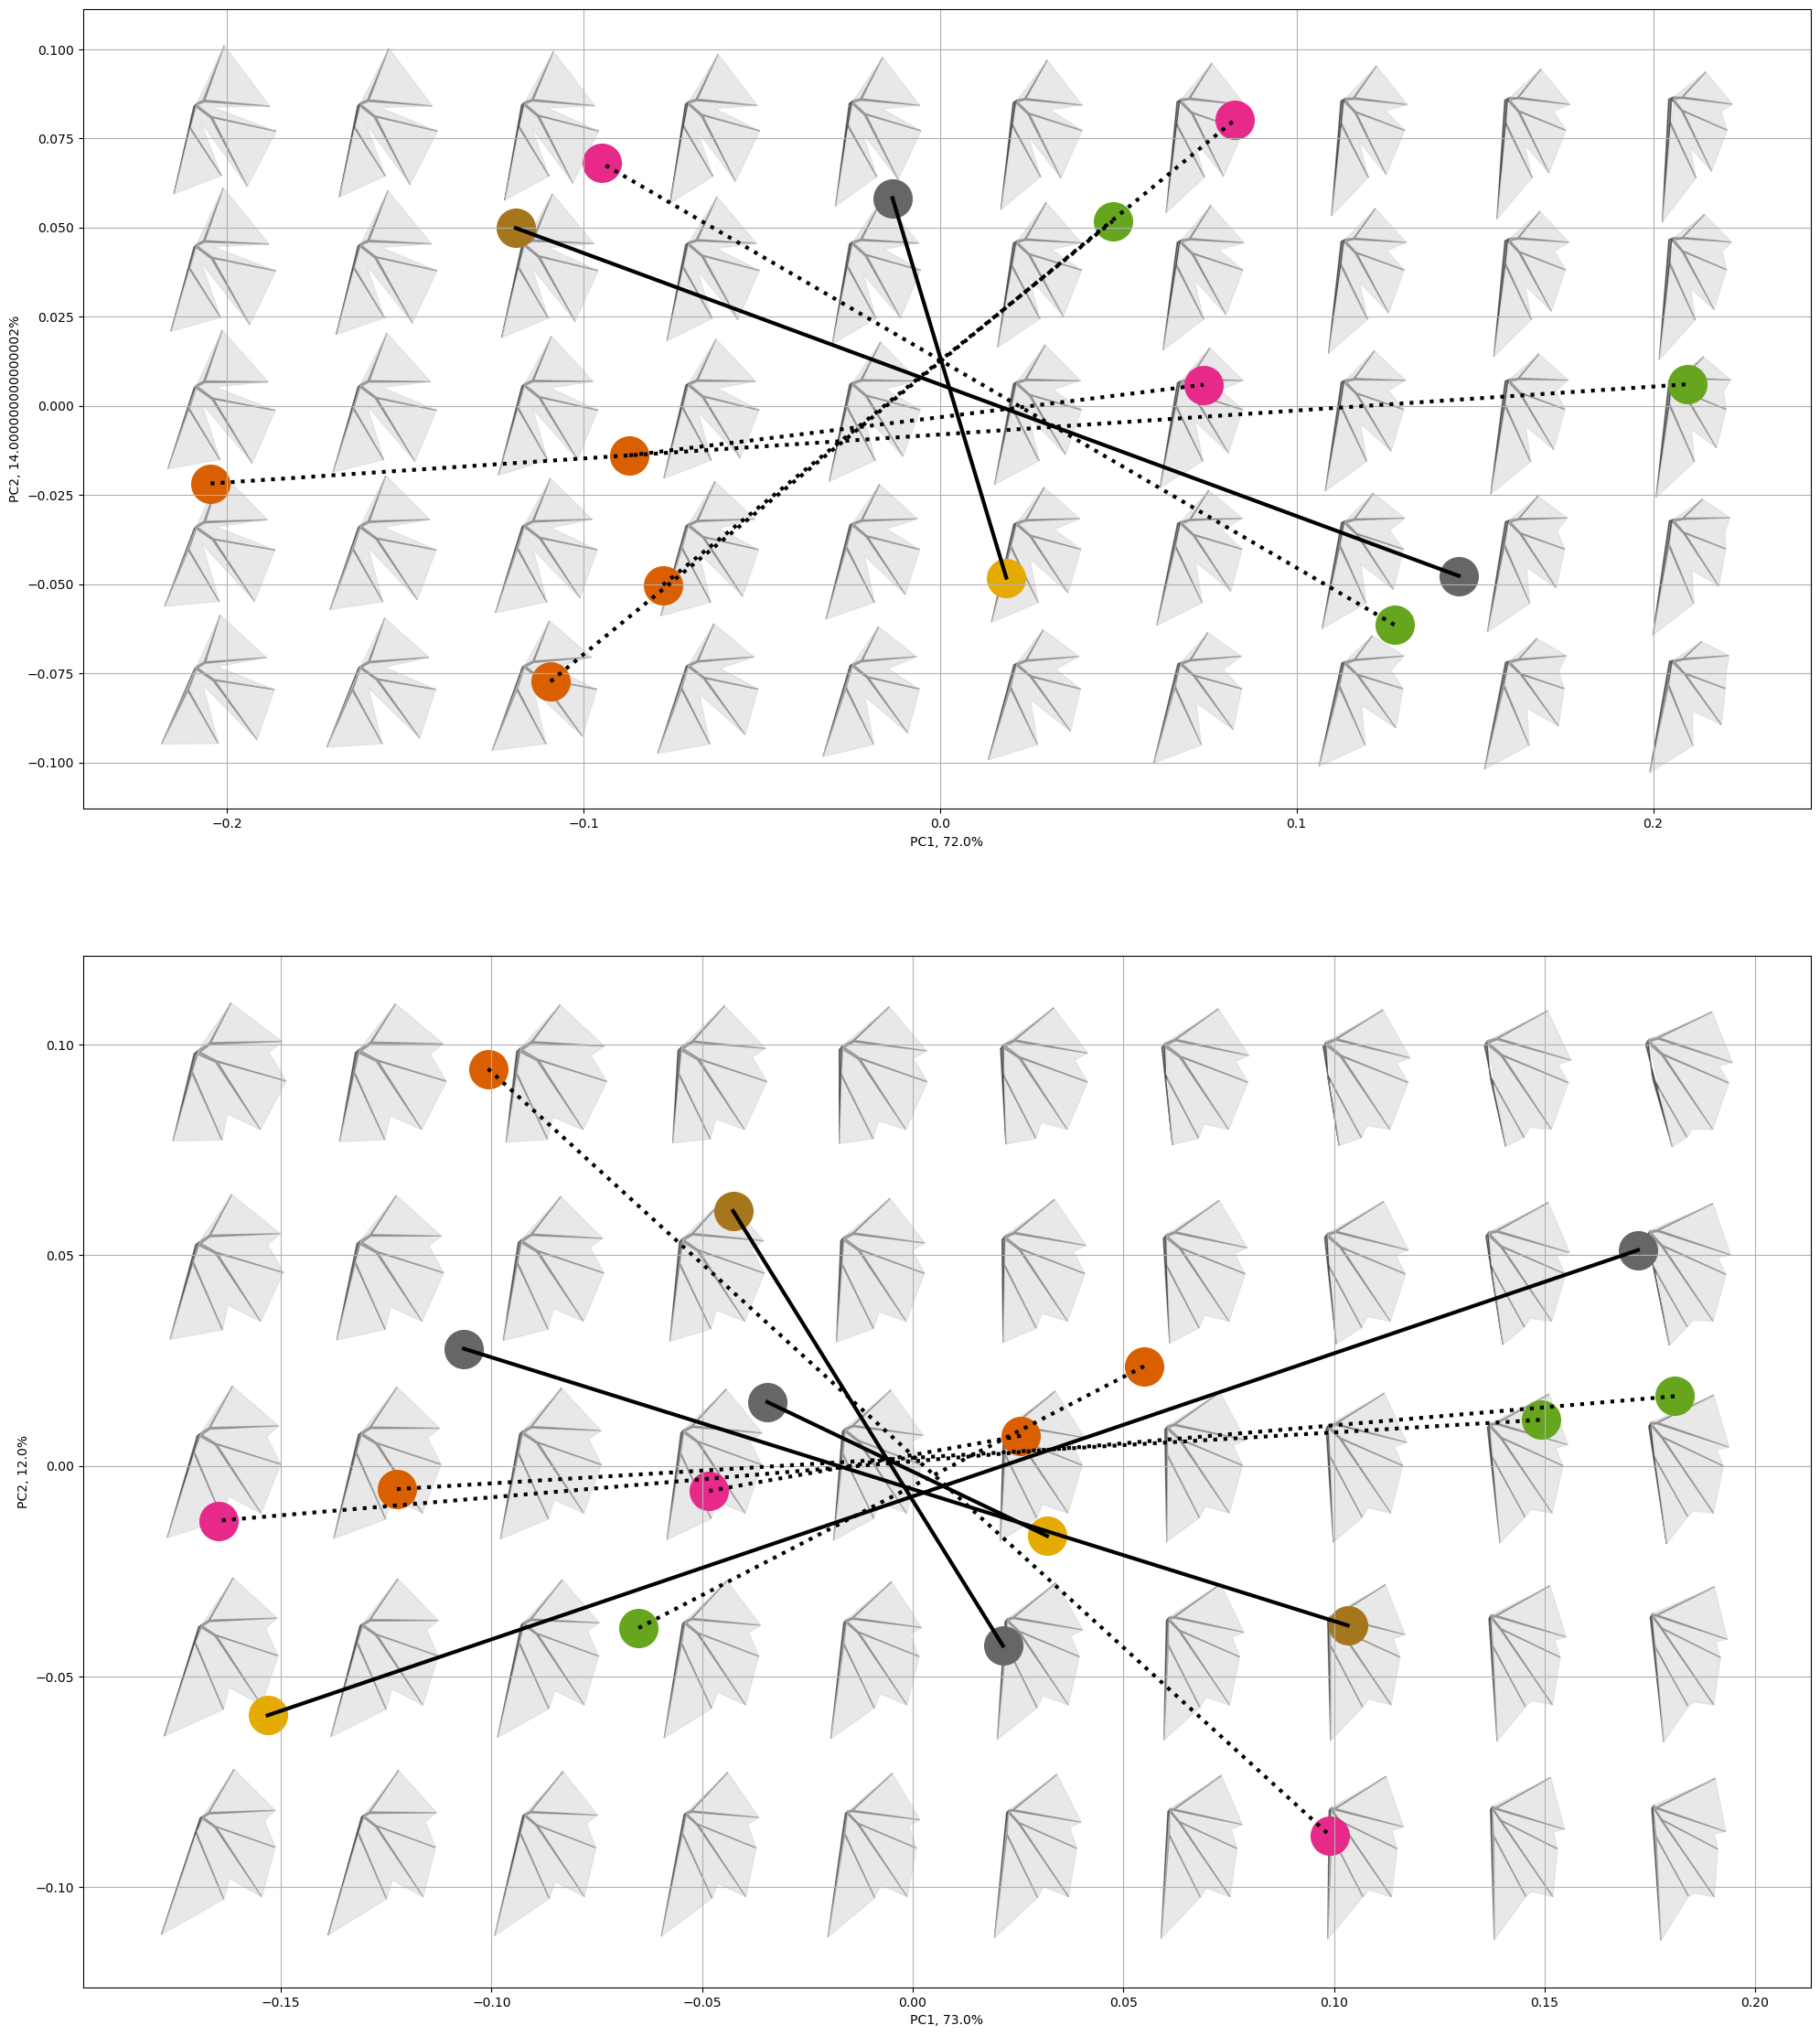

In [28]:
pt_s = 900
linewidth = 3
cab_xlab = "PC1, " + str(np.round(cab_pca_all.explained_variance_ratio_[0],2)*100) + "%" # x-axis label
cab_ylab = "PC2, " + str(np.round(cab_pca_all.explained_variance_ratio_[1],2)*100) + "%" # y-axis label
chard_xlab = "PC1, " + str(np.round(chard_pca_all.explained_variance_ratio_[0],2)*100) + "%" # x-axis label
chard_ylab = "PC2, " + str(np.round(chard_pca_all.explained_variance_ratio_[1],2)*100) + "%" # y-axis label

eigen_blade_col = "lightgray" # set eigenleaf blade color
eigen_vein_col = "black" # set eigenleaf vein color
eigen_blade_a = 0.5 # set eigenleaf blade alpha
eigen_vein_a = 0.5 # set eigenleaf vein alpha
s = 0.05 # scale

numPC1 = 10
numPC2 = 5

cab_PC1_vals = np.linspace( np.min(cab_PCs[:,0]), np.max(cab_PCs[:,0]), numPC1 ) # create cab intervals
cab_PC2_vals = np.linspace( np.min(cab_PCs[:,1]), np.max(cab_PCs[:,1]), numPC2 )
chard_PC1_vals = np.linspace( np.min(chard_PCs[:,0]), np.max(chard_PCs[:,0]), numPC1 ) # create chard intervals
chard_PC2_vals = np.linspace( np.min(chard_PCs[:,1]), np.max(chard_PCs[:,1]), numPC2 )


plt.figure(figsize=(20,24))

ax1 = plt.subplot(2,1,1)

for i in cab_PC1_vals:
    for j in cab_PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = cab_pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax1.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax1.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)

for i in range(int(len(cab_pca_df)/2)):
    
    if cab_pca_df["type"].iloc[i*2]=="root":
        line_style = "solid"
    elif cab_pca_df["type"].iloc[i*2]=="loc":
        line_style = "dotted"
    
    ax1.plot( [cab_pca_df["PC1"].iloc[i*2],cab_pca_df["PC1"].iloc[i*2+1]],
              [cab_pca_df["PC2"].iloc[i*2],cab_pca_df["PC2"].iloc[i*2+1]],
             linestyle=line_style, c="k", lw=linewidth
            )
   
for i in range(len(cab_pca_df)):
    ax1.scatter(cab_pca_df["PC1"].iloc[i], 
                cab_pca_df["PC2"].iloc[i], 
                c=cab_pca_df["col"].iloc[i], s=pt_s) 
    
ax1.set_aspect("equal")
ax1.grid("on")
ax1.set_xlabel(cab_xlab)
ax1.set_ylabel(cab_ylab)


ax2 = plt.subplot(2,1,2)

for i in chard_PC1_vals:
    for j in chard_PC2_vals:
        
        pc1_val = i
        pc2_val = j

        inv_leaf = chard_pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2]
        inv_y = inv_leaf[1::2]
        
        vn_xvals = np.array([inv_x[x] for x in vein_indices])
        vn_yvals = np.array([inv_y[x] for x in vein_indices])
        
        bl_xvals = np.array([inv_x[x] for x in blade_indices])
        bl_yvals = np.array([inv_y[x] for x in blade_indices])
        
        ax2.fill(vn_xvals*s+pc1_val, vn_yvals*s+pc2_val, c=eigen_vein_col, alpha=eigen_vein_a)
        ax2.fill(bl_xvals*s+pc1_val, bl_yvals*s+pc2_val, c=eigen_blade_col, alpha=eigen_blade_a)

for i in range(int(len(chard_pca_df)/2)):
    
    if chard_pca_df["type"].iloc[i*2]=="root":
        line_style = "solid"
    elif chard_pca_df["type"].iloc[i*2]=="loc":
        line_style = "dotted"
    
    ax2.plot( [chard_pca_df["PC1"].iloc[i*2],chard_pca_df["PC1"].iloc[i*2+1]],
              [chard_pca_df["PC2"].iloc[i*2],chard_pca_df["PC2"].iloc[i*2+1]],
             linestyle=line_style, c="k", lw=linewidth
            )
   
for i in range(len(chard_pca_df)):
    ax2.scatter(chard_pca_df["PC1"].iloc[i], 
                chard_pca_df["PC2"].iloc[i], 
                c=chard_pca_df["col"].iloc[i], s=pt_s) 
    
ax2.set_aspect("equal")
ax2.grid("on")
ax2.set_xlabel(chard_xlab)
ax2.set_ylabel(chard_ylab)

plt.tight_layout()

#plt.savefig("PCA_differences.jpg")

# Compare vein-to-blade ratios

In [29]:
vtb_PC1_vals = np.linspace( -0.2, +0.2, 1000)
cab_vtb = []
chard_vtb = []

for i in range(len(vtb_PC1_vals)):
    
    if i%100==0:
        print(i)
    
    pc1_val = vtb_PC1_vals[i]
    pc2_val = 0
    
    cab_inv_leaf = cab_pca.inverse_transform(np.array([pc1_val,pc2_val]))
    chard_inv_leaf = chard_pca.inverse_transform(np.array([pc1_val,pc2_val]))
    
    cab_vein_x = cab_inv_leaf[0::2][vein_indices]
    cab_vein_y = cab_inv_leaf[1::2][vein_indices]
    cab_blade_x = cab_inv_leaf[0::2][blade_indices]
    cab_blade_y = cab_inv_leaf[1::2][blade_indices]
    cab_vein_area = PolyArea(cab_vein_x, cab_vein_y)
    cab_blade_area = PolyArea(cab_blade_x, cab_blade_y)-cab_vein_area
    cab_vtb.append(cab_vein_area/cab_blade_area)
    
    chard_vein_x = chard_inv_leaf[0::2][vein_indices]
    chard_vein_y = chard_inv_leaf[1::2][vein_indices]
    chard_blade_x = chard_inv_leaf[0::2][blade_indices]
    chard_blade_y = chard_inv_leaf[1::2][blade_indices]
    chard_vein_area = PolyArea(chard_vein_x, chard_vein_y)
    chard_blade_area = PolyArea(chard_blade_x, chard_blade_y)-chard_vein_area
    chard_vtb.append(chard_vein_area/chard_blade_area)


0
100
200
300
400
500
600
700
800
900


#### Plot vein-to-blade ratio across PC1 values for Cab and Chard

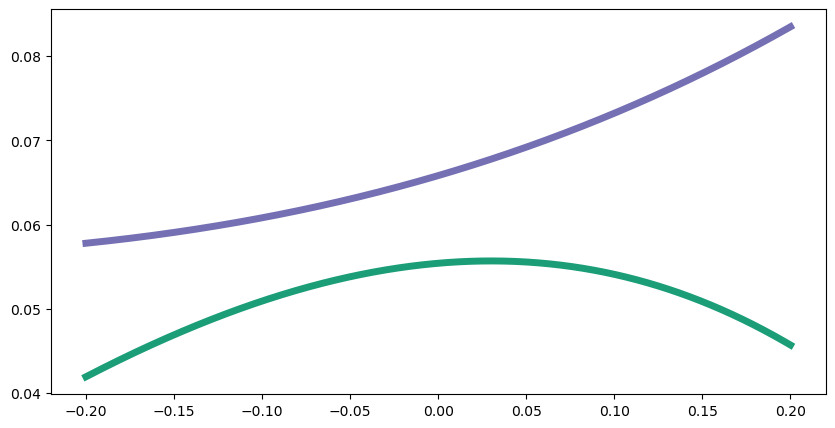

In [30]:
plt.figure(figsize=(10,5))
plt.plot(vtb_PC1_vals, cab_vtb, c=cab_col, lw=5)
plt.plot(vtb_PC1_vals, chard_vtb, c=chard_col, lw=5)

#plt.savefig("vtb_PC1_cab_chard.jpg")